In [0]:
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape

170500096/170498071 [==============================] - 15s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

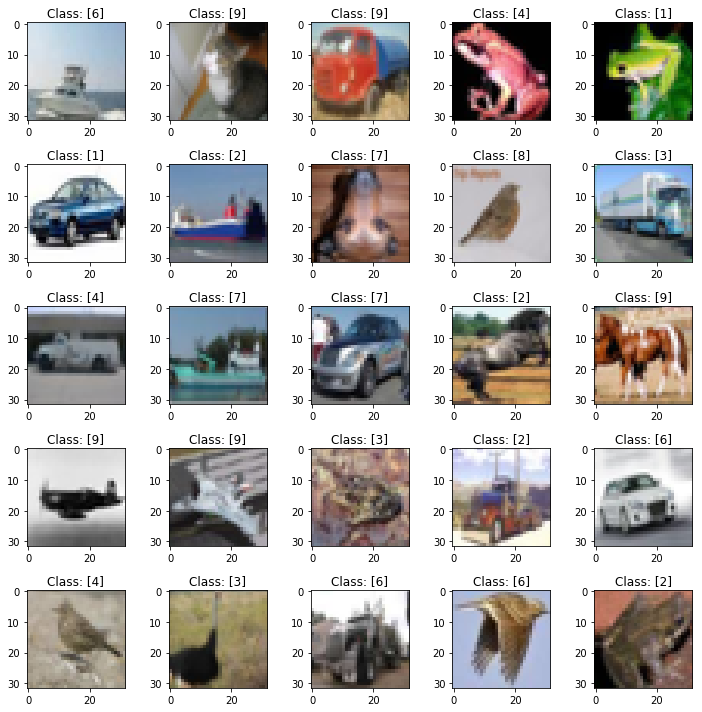

In [61]:
fig = plt.figure(figsize = (10, 10))
for idx in range(25):
    plt.subplot(5, 5, idx+1)
    plt.imshow(X_train[idx+100])
    plt.title('Class: {}'.format(y_train[idx]))

plt.tight_layout()

In [3]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

num_channels = 3
X_train = X_train.reshape(-1, img_rows, img_cols, num_channels)
X_test = X_test.reshape(-1, img_rows, img_cols, num_channels)

input_shape = (img_rows, img_cols, num_channels)

X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
if np.max(X_train) > 1: X_train = X_train/255
if np.max(X_test) > 1: X_test = X_test/255

In [0]:
if len(y_train.shape) == 2:
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)
  
if len(y_train.shape) == 1:
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)



In [6]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), input_shape=input_shape), MaxPool2D(pool_size=(2,2)),
    Dropout(0.25), 
    
    Conv2D(filters = 64, kernel_size = (3,3), input_shape=input_shape), MaxPool2D(pool_size=(2,2)),
    Dropout(0.25), 
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation = 'softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [12]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
  model,
  strategy=tf.contrib.tpu.TPUDistributionStrategy(
  tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.63.168.234:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2410068590853496325)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3462035513201001025)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5822193639610159795)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [13]:
tpu_model.fit(
    X_train, y_train,
    batch_size=128*8,
    epochs=20,
    validation_split=0.2
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(128, 10), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f175bd03a90> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.9350922107696533 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU

In [15]:
tpu_model.evaluate(X_test, y_test)

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(4, 10), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f1759522b00> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.2226831912994385 secs
 9984/10000 [============================>.] - ETA: 0s - loss: 0.9012 - acc: 0.6956INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(2, 10), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default pl

[0.9009803267478943, 0.6956]